### 1. Detect the outlier by RANSACRegressor
    There is an outlier in feature 'TOUCH_TIME', so we alter it into median of 'TOUCH_TIME'.
    
### 2. Get the top-3 features by PCA selection
    the top-3 features: 'DRIBBLES', 'SHOT_DIST', and 'CLOSE_DEF_DIST'
    
### 3. Trained with the top-3 features, use linear regression, ridge regression, and decision tree to train the model, evaluate the model with accuracy and MSE
    validation results:

        [linear regression]
            Accuracy: 0.61
            MSE: 0.39

        [ridge regression (degree = 2)]
            Accuracy: 0.61
            MSE: 0.39

        [decision tree]
            Accuracy: 0.63
            MSE: 0.37

    From the results above, we choose decision tree to be our training model.
    
### 4. Messages from the error curve
    From the error curve plot below, we can tell that the MSE is the lowest when the tree depth is 4.
    And the Accuracy is the highest when the tree depth is 4.
    So we choose the tree's max_depth to be 4 to avoid overfitting and to get the best predict ability.

In [1]:
# prepare the library and the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, RANSACRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, accuracy_score

import warnings
warnings.filterwarnings("ignore")

X_train = pd.read_csv('D:/深度學習/homework/data/nba/X_train.csv')
y_train = pd.read_csv('D:/深度學習/homework/data/nba/y_train.csv')
X_test = pd.read_csv('D:/深度學習/homework/data/nba/X_test.csv')

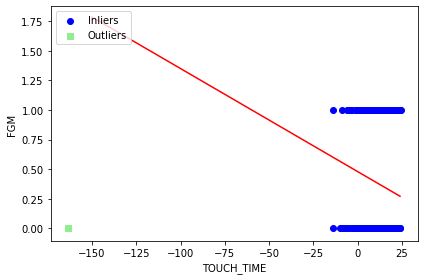

In [2]:
# find the outlier of column [TOUCH_TIME]
X = X_train['TOUCH_TIME'].values[:, np.newaxis]
y = y_train.values

ransac = RANSACRegressor(LinearRegression(), max_trials=100, min_samples=50, residual_threshold=5.0, random_state=0)
ransac.fit(X, y)

inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(-150, 25, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask], c='blue', marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], c='lightgreen', marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='red')
plt.xlabel('TOUCH_TIME')
plt.ylabel('FGM')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [3]:
# alter the outlier of [TOUCH_TIME] into median
outlier = X_train['TOUCH_TIME'].min()
median_val = X_train['TOUCH_TIME'].median()
X_train['TOUCH_TIME'][X_train['TOUCH_TIME'] == outlier] = median_val

In [4]:
# use PCA to select top-3 features
pca = PCA(n_components=3)
pca.fit_transform(X_train)
print(pd.DataFrame(pca.components_, columns=X_train.columns, index = ['PC-1','PC-2','PC-3']))

        PERIOD  GAME_CLOCK  SHOT_CLOCK  DRIBBLES  TOUCH_TIME  SHOT_DIST  \
PC-1 -0.000153    0.999992    0.002970 -0.002002   -0.001542  -0.000789   
PC-2  0.003045    0.001185   -0.194514 -0.044229   -0.036023   0.964588   
PC-3  0.006304    0.003282   -0.955496  0.158501    0.160339  -0.162133   

      PTS_TYPE  CLOSE_DEF_DIST  
PC-1 -0.000104        0.000080  
PC-2  0.035376        0.164979  
PC-3 -0.013179       -0.098417  


In [5]:
# use only the selected features
X_train = X_train[['DRIBBLES', 'SHOT_DIST', 'CLOSE_DEF_DIST']]

# split training data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

In [6]:
# linear regression
reg = LinearRegression()
reg.fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
y_val_pred = reg.predict(X_val)
y_val_pred[y_val_pred>=0.5] = 1
y_val_pred[y_val_pred<0.5] = 0
print('Accuracy: %.2f' % accuracy_score(y_val, y_val_pred))
print('MSE: %.2f' % mean_squared_error(y_val, y_val_pred))

Accuracy: 0.61
MSE: 0.39


In [7]:
# ridge regression
rg = Ridge(alpha=100)
rg.fit(X_train, y_train)
y_train_pred = rg.predict(X_train)
y_valid_pred = rg.predict(X_val)
y_valid_pred[y_valid_pred>=0.5] = 1
y_valid_pred[y_valid_pred<0.5] = 0
print('Accuracy: %.2f' % accuracy_score(y_val, y_valid_pred))
print('MSE valid: %.2f' % mean_squared_error(y_val, y_valid_pred))

Accuracy: 0.61
MSE valid: 0.39


In [12]:
# decision tree
tree = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=0)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_val)
print('Accuracy: %.2f' % accuracy_score(y_val, y_pred))
print('MSE: %.2f' % mean_squared_error(y_val, y_pred))

Accuracy: 0.63
MSE: 0.37


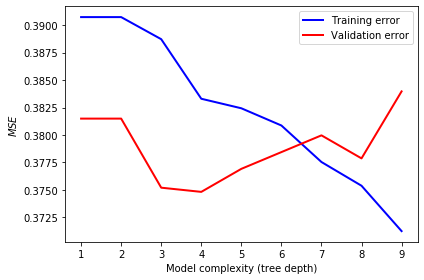

In [9]:
# plot the error curve for the decision tree (MSE)
mse_train = []
mse_validation = []

for d in range(1, 10):
    tree = DecisionTreeClassifier(criterion='entropy', max_depth=d, random_state=0)
    treer = tree.fit(X_train, y_train)
    y_train_pred = treer.predict(X_train)
    y_val_pred = treer.predict(X_val)
    mse_train.append(mean_squared_error(y_train, y_train_pred))
    mse_validation.append(mean_squared_error(y_val, y_val_pred))
    
plt.plot(range(1, 10), mse_train, label = 'Training error', color = 'blue', linewidth = 2)
plt.plot(range(1, 10), mse_validation, label = 'Validation error', color = 'red', linewidth = 2)
plt.legend(loc='upper right')
plt.xlabel('Model complexity (tree depth)')
plt.ylabel('$MSE$')
plt.tight_layout()
plt.show()

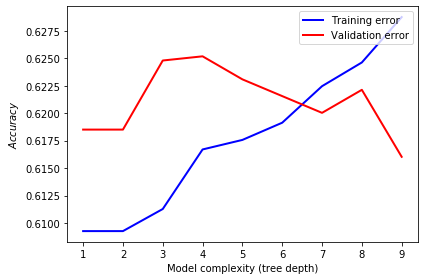

In [10]:
# plot the error curve for the decision tree (accuracy)
mse_train = []
mse_validation = []

for d in range(1, 10):
    tree = DecisionTreeClassifier(criterion='entropy', max_depth=d, random_state=0)
    treer = tree.fit(X_train, y_train)
    y_train_pred = treer.predict(X_train)
    y_val_pred = treer.predict(X_val)
    mse_train.append(accuracy_score(y_train, y_train_pred))
    mse_validation.append(accuracy_score(y_val, y_val_pred))
    
plt.plot(range(1, 10), mse_train, label = 'Training error', color = 'blue', linewidth = 2)
plt.plot(range(1, 10), mse_validation, label = 'Validation error', color = 'red', linewidth = 2)
plt.legend(loc='upper right')
plt.xlabel('Model complexity (tree depth)')
plt.ylabel('$Accuracy$')
plt.tight_layout()
plt.show()

In [11]:
# predict the X_test data
tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
tree.fit(X_train, y_train)

X_test = X_test[['GAME_CLOCK','SHOT_CLOCK','SHOT_DIST']]
y_pred = tree.predict(X_test)
pd.DataFrame(y_pred).to_csv('D:/深度學習/homework/y_pred.csv', header=['FGM'])